In [1]:
!pip install torchsummary

In [2]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from tqdm import tqdm
import time
from torchvision import models

# For Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

In [3]:
%matplotlib inline

In [4]:
data_dir = "../input/plantvillagecolor/color"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [5]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [6]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [7]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of plants: 14
Unique Plants are: 
1. Tomato
2. Grape
3. Orange
4. Soybean
5. Squash
6. Potato
7. Corn_(maize)
8. Strawberry
9. Peach
10. Apple
11. Blueberry
12. Cherry_(including_sour)
13. Pepper,_bell
14. Raspberry


In [8]:
# number of unique diseases
print("Total number of diseases: {}".format(NumberOfDiseases))


Total number of diseases: 26


In [9]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Late_blight                                         1909
Tomato___healthy                                             1591
Grape___healthy                                               423
Orange___Haunglongbing_(Citrus_greening)                     5507
Soybean___healthy                                            5090
Squash___Powdery_mildew                                      1835
Potato___healthy                                              152
Corn_(maize)___Northern_Leaf_Blight                           985
Tomato___Early_blight                                        1000
Tomato___Septoria_leaf_spot                                  1771
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot            513
Strawberry___Leaf_scorch                                     1109
Peach___healthy                                               360
Apple___Apple_scab                                            630
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       5357
Tomato___Bacterial_spot                                      2127
Apple___Black_rot                                             621
Blueberry___healthy                                          1502
Cherry_(including_sour)___Powdery_mildew                     1052
Peach___Bacterial_spot                                       2297
Apple___Cedar_apple_rust                                      275
Tomato___Target_Spot                                         1404
Pepper,_bell___healthy                                       1478
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1076
Potato___Late_blight                                         1000
Tomato___Tomato_mosaic_virus                                  373
Strawberry___healthy                                          456
Apple___healthy                                              1645
Grape___Black_rot                                            1180
Potato___Early_blight                                        1000
Cherry_(including_sour)___healthy                             854
Corn_(maize)___Common_rust_                                  1192
Grape___Esca_(Black_Measles)                                 1383
Raspberry___healthy                                           371
Tomato___Leaf_Mold                                            952
Tomato___Spider_mites Two-spotted_spider_mite                1676
Pepper,_bell___Bacterial_spot                                 997
Corn_(maize)___healthy                                       1162

Text(0.5, 1.0, 'Images per each class of plant disease')

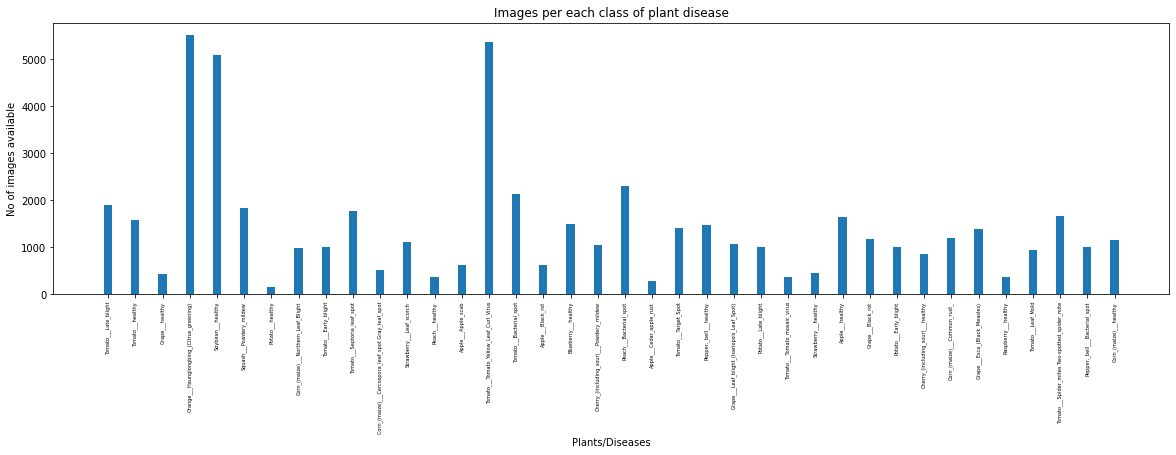

In [10]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [11]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            # transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225]),
            #transforms.Resize(224)
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [12]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [13]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 35


In [14]:
# TODO: Correct it

print(f"There are {len(train_dataset) + len(validation_dataset) + len(test_dataset)} images in total")

print(f"There are {len(train_dataset)} images for training")

print(f"There are {len(validation_dataset)} images for validation")

print(f"There are {len(test_dataset)} images for testing")

There are 54305 images in total
There are 38014 images for training
There are 5430 images for validation
There are 10861 images for testing


In [15]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

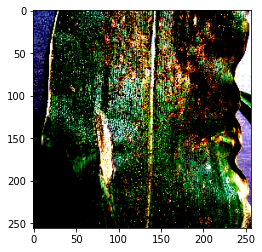

In [16]:
show_image(*train_dataset[21])

In [17]:
# Setting the seed value
random_seed = 7
a = torch.manual_seed(random_seed)


In [18]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [19]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

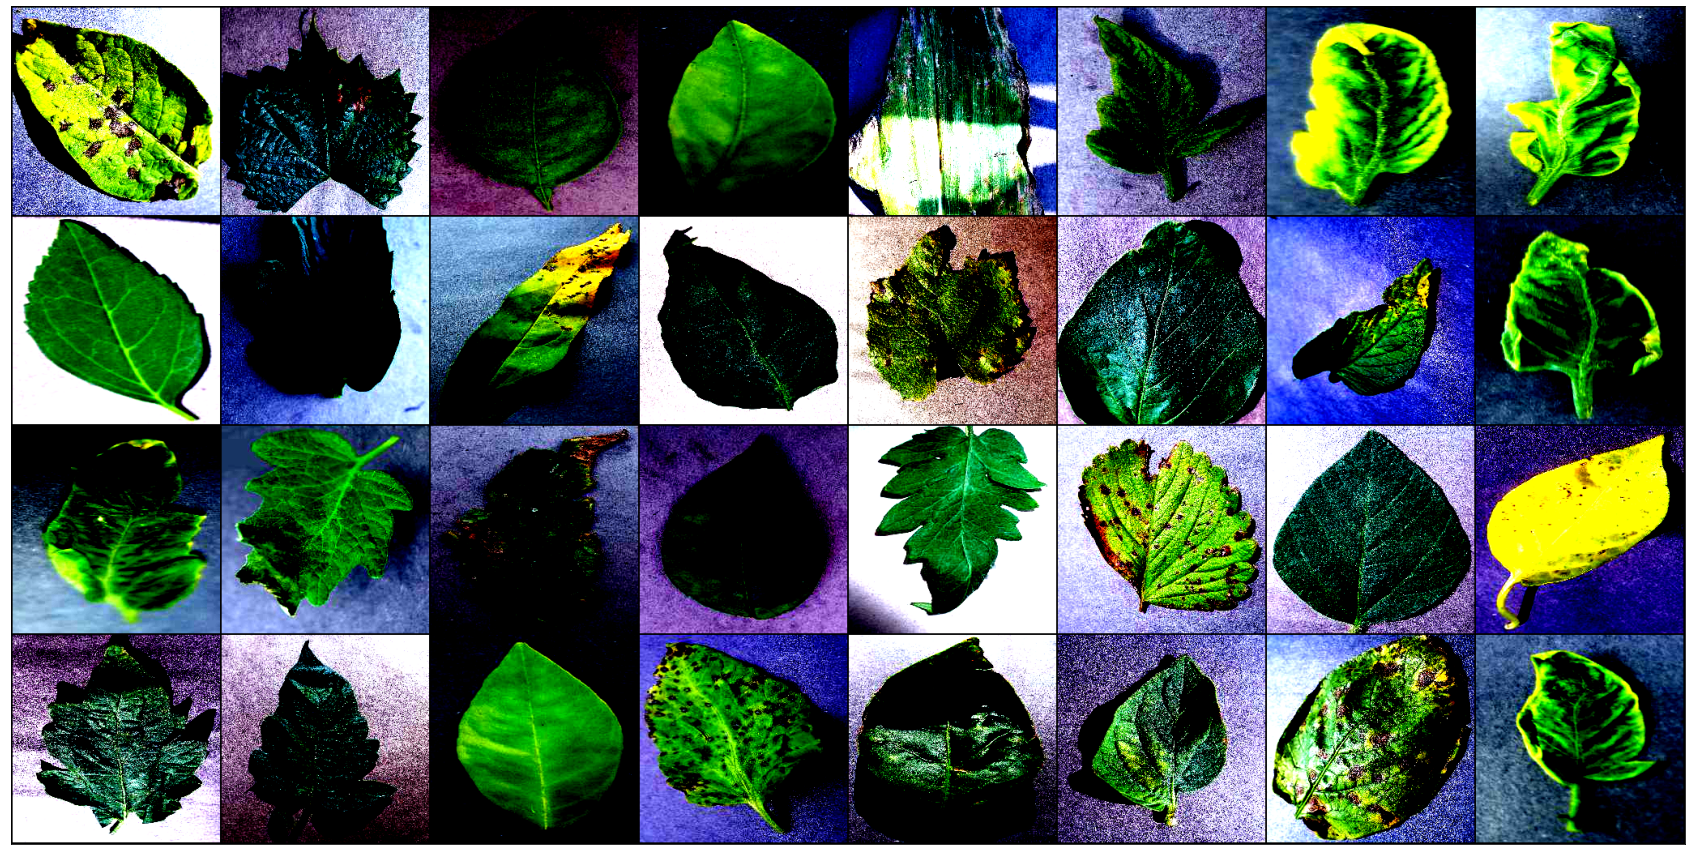

In [20]:
show_batch(train_dataloader)

In [21]:
# TODO: Remove. get_default_device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

cuda:0


In [22]:
# Moving data into GPU
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)

In [23]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [24]:
# defining the model and moving it to the GPU

model_vgg16 = models.vgg16(pretrained=False)
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=len(train_dataset.dataset.classes))
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model_vgg16.cuda(), (INPUT_SHAPE)))
# print(summary(model.cpu(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [27]:
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=0.001)

In [28]:
loss_fn = nn.CrossEntropyLoss()

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_vgg16.to(device)

accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []


num_epochs = 40
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
#        model_resnet50.train()
        outputs = model_vgg16(images)
        loss = loss_fn(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_vgg16.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_vgg16(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                val_loss = loss_fn(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/40], Step [100/1188], Loss: 3.3001, Accuracy: 15.62%
Epoch [1/40], Loss: 3.2765, Validation Accuracy: 17.53%
Epoch [1/40], Step [200/1188], Loss: 2.9489, Accuracy: 9.38%
Epoch [1/40], Loss: 2.9789, Validation Accuracy: 19.50%
Epoch [1/40], Step [300/1188], Loss: 2.5108, Accuracy: 37.50%
Epoch [1/40], Loss: 2.9241, Validation Accuracy: 28.32%
Epoch [1/40], Step [400/1188], Loss: 2.4823, Accuracy: 28.12%
Epoch [1/40], Loss: 2.9603, Validation Accuracy: 30.55%
Epoch [1/40], Step [500/1188], Loss: 2.4172, Accuracy: 31.25%
Epoch [1/40], Loss: 2.5196, Validation Accuracy: 35.82%
Epoch [1/40], Step [600/1188], Loss: 1.7695, Accuracy: 53.12%
Epoch [1/40], Loss: 2.7113, Validation Accuracy: 34.48%
Epoch [1/40], Step [700/1188], Loss: 1.6745, Accuracy: 46.88%
Epoch [1/40], Loss: 1.7800, Validation Accuracy: 51.55%
Epoch [1/40], Step [800/1188], Loss: 1.9481, Accuracy: 28.12%
Epoch [1/40], Loss: 1.8960, Validation Accuracy: 55.76%
Epoch [1/40], Step [900/1188], Loss: 1.599

In [30]:
print(accuracy_train)

[15.625, 9.375, 37.5, 28.125, 31.25, 53.125, 46.875, 28.125, 43.75, 53.125, 78.125, 62.5, 56.25, 65.625, 59.375, 65.625, 84.375, 78.125, 75.0, 75.0, 75.0, 84.375, 84.375, 87.5, 93.75, 81.25, 87.5, 87.5, 84.375, 84.375, 84.375, 78.125, 68.75, 75.0, 81.25, 81.25, 93.75, 87.5, 81.25, 96.875, 100.0, 84.375, 87.5, 90.625, 87.5, 93.75, 96.875, 87.5, 90.625, 96.875, 84.375, 93.75, 90.625, 87.5, 96.875, 84.375, 90.625, 90.625, 90.625, 93.75, 96.875, 87.5, 96.875, 93.75, 81.25, 93.75, 93.75, 93.75, 100.0, 96.875, 93.75, 90.625, 96.875, 96.875, 96.875, 87.5, 93.75, 93.75, 96.875, 96.875, 93.75, 100.0, 93.75, 100.0, 96.875, 90.625, 93.75, 90.625, 96.875, 96.875, 100.0, 100.0, 96.875, 96.875, 90.625, 93.75, 93.75, 87.5, 84.375, 90.625, 93.75, 96.875, 96.875, 96.875, 90.625, 96.875, 100.0, 100.0, 96.875, 96.875, 96.875, 90.625, 100.0, 93.75, 96.875, 90.625, 93.75, 93.75, 93.75, 96.875, 96.875, 100.0, 93.75, 93.75, 93.75, 100.0, 96.875, 93.75, 90.625, 96.875, 90.625, 100.0, 93.75, 96.875, 90.625, 96

In [31]:
print(accuracy_validation)

[17.532228360957642, 19.502762430939228, 28.32412523020258, 30.5524861878453, 35.819521178637196, 34.47513812154696, 51.546961325966855, 55.76427255985267, 56.16942909760589, 56.39042357274402, 62.081031307550646, 70.11049723756906, 69.35543278084715, 69.76058931860037, 73.35174953959485, 71.87845303867402, 77.73480662983425, 77.32965009208102, 73.72007366482505, 79.13443830570903, 79.77900552486187, 80.75506445672191, 83.84898710865562, 80.47882136279927, 79.48434622467772, 83.68324125230203, 85.24861878453038, 85.72744014732965, 82.94659300184162, 85.67219152854511, 81.67587476979742, 86.50092081031308, 85.6353591160221, 86.09576427255985, 82.46777163904235, 88.15837937384899, 83.48066298342542, 88.17679558011051, 88.21362799263352, 88.98710865561694, 88.69244935543279, 76.48250460405156, 85.41436464088397, 80.16574585635358, 89.17127071823204, 87.4401473296501, 86.99815837937385, 84.64088397790054, 87.91896869244935, 87.64272559852671, 89.13443830570903, 88.65561694290976, 89.429097

In [32]:
print(loss_validation)

[3.2765097618103027, 2.9789369106292725, 2.9240670204162598, 2.9602859020233154, 2.519604206085205, 2.711297035217285, 1.7800087928771973, 1.895966649055481, 1.7157024145126343, 1.7550098896026611, 1.6645965576171875, 1.4263592958450317, 1.2343723773956299, 0.9122515320777893, 1.09013032913208, 1.0716028213500977, 0.7944666147232056, 0.9455087184906006, 0.8128488063812256, 0.9448890089988708, 0.5952996611595154, 0.6341168880462646, 0.5821982026100159, 0.9973258376121521, 1.1028201580047607, 0.521871030330658, 0.469136118888855, 0.8716413974761963, 0.6033177971839905, 0.415418803691864, 0.7200682163238525, 0.4504286050796509, 0.8156833052635193, 0.7851523756980896, 0.7450478076934814, 0.4425993859767914, 0.42777642607688904, 0.3522174656391144, 0.4377506375312805, 0.48517072200775146, 0.26779165863990784, 0.6247571110725403, 0.747589647769928, 1.2218960523605347, 0.5678866505622864, 0.429714560508728, 0.7184455990791321, 0.5120060443878174, 0.5334847569465637, 0.4694456160068512, 0.2347

In [33]:
print(loss_train)

[3.300107002258301, 2.948859214782715, 2.5107839107513428, 2.4823355674743652, 2.4172182083129883, 1.7695330381393433, 1.67446768283844, 1.9480774402618408, 1.5996644496917725, 1.5482592582702637, 0.9180484414100647, 0.9818156957626343, 1.32666015625, 0.9321381449699402, 1.070554256439209, 0.8946513533592224, 0.43723011016845703, 0.5905316472053528, 0.8014190793037415, 0.9735747575759888, 0.903550922870636, 0.5978161096572876, 0.4898969531059265, 0.4718393087387085, 0.37896665930747986, 0.6581842303276062, 0.4128398597240448, 0.3659663796424866, 0.7099726796150208, 0.5160409212112427, 0.5099254250526428, 0.5273391008377075, 1.4047493934631348, 0.700757622718811, 0.3432171046733856, 0.6230942010879517, 0.20698697865009308, 0.29252830147743225, 0.34685635566711426, 0.16629256308078766, 0.0970650464296341, 0.5527892112731934, 0.337257444858551, 0.2563900947570801, 0.3114265203475952, 0.44793930649757385, 0.12189903110265732, 0.38263005018234253, 0.2548562288284302, 0.11249741166830063, 0.

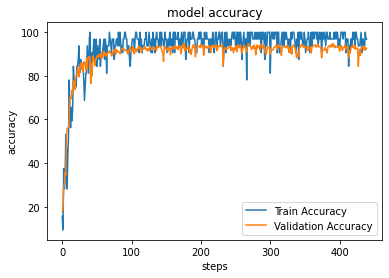

In [34]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Accurary_Plot_PlantVillage-vgg16')
plt.show()

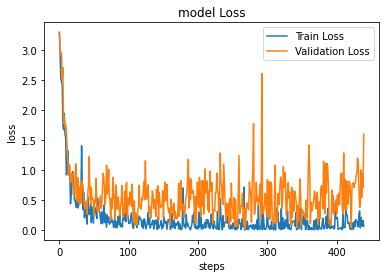

In [35]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Loss_Plot_PlantVillage-vgg16')
plt.show()

In [36]:
torch.save(model_vgg16, '/kaggle/working/Model_PlantVillage-vgg16.pth')
# model = torch.load('model.pth')

In [37]:
model_vgg16.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in validation_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_vgg16(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))

Accuracy on Validation Set: 93.37%


In [38]:
y_pred = []
y_true = []
features_tsne = None

model_vgg16.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_vgg16(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()
        
        prediction_result = test_prediction.data.cpu().numpy()
        gt_label = test_labels.data.cpu().numpy()
        
        y_pred.extend(prediction_result) # Save Prediction
        y_true.extend(gt_label) # Save Truth
        
        # For t-SNE
        curr_f = predicted_outputs.cpu().numpy()
        if features_tsne is not None:
            features_tsne = np.concatenate((features_tsne, curr_f))
        else:
            features_tsne = curr_f
        
    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))

Accuracy on Test Set: 93.28%


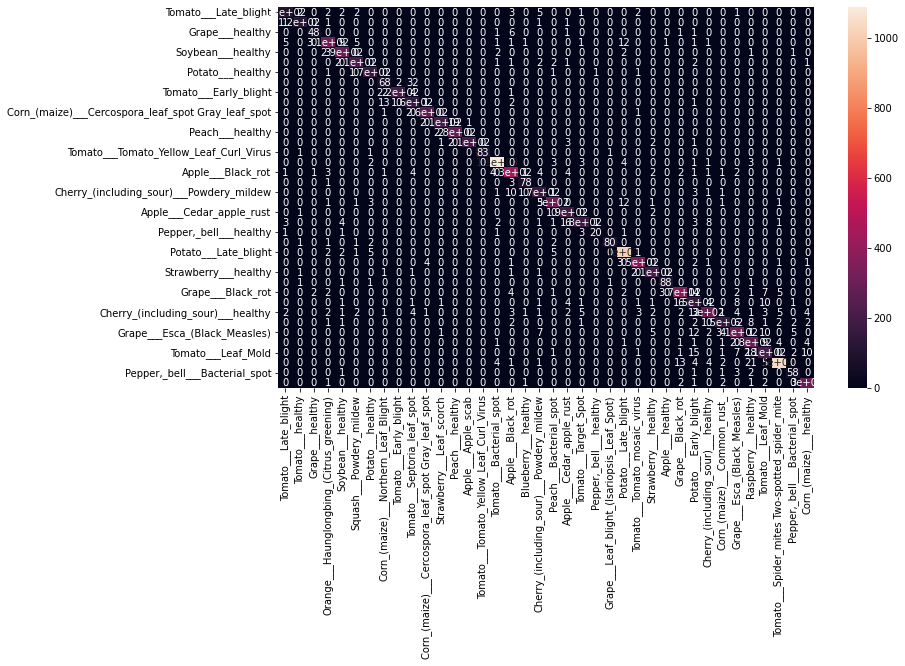

In [39]:
confusion_matrix_vec = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(confusion_matrix_vec,
                     index = [i for i in diseases],
                     columns = [i for i in diseases])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/working/Confusion_Matrix_PlantVillage-vgg16.png')

In [40]:
# (True Positive + True Negative) / Total Predictions
accuracy = accuracy_score(y_true, y_pred)

# True Positive / (True Positive + False Positive)
precision = precision_score(y_true, y_pred, average='weighted')

# True Positive / (True Positive + False Negative)
sensitivity_recall = recall_score(y_true, y_pred, average='weighted')

# True Negative / (True Negative + False Positive)
specificity = recall_score(y_true, y_pred, average='weighted')

# 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
f1_score = f1_score(y_true, y_pred, average='weighted')
      
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Sensitivity_recall: {:.2f}%".format(sensitivity_recall*100))
print("Specificity: {:.2f}%".format(specificity*100))
print("F1 Score: {:.2f}%".format(f1_score*100))

Accuracy: 93.28%
Precision: 93.45%
Sensitivity_recall: 93.28%
Specificity: 93.28%
F1 Score: 93.29%


In [41]:
## TSNE ##

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate= 'auto', init='random').fit_transform(features_tsne)

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def visualize_both_tsne_points(diseases, tx1, ty1, labels1, tx2, ty2, labels2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
    
    for disease_index in range(len(diseases)):
        ax1.title.set_text(title1)
        indices = [i for i, l in enumerate(labels1) if l == disease_index]
        current_tx = np.take(tx1, indices)
        current_ty = np.take(ty1, indices)
        ax1.scatter(current_tx, current_ty, label=diseases[disease_index])

    for disease_index in range(len(diseases)):
        ax2.title.set_text(title2)
        indices = [i for i, l in enumerate(labels2) if l == disease_index]
        current_tx = np.take(tx2, indices)
        current_ty = np.take(ty2, indices)
        ax2.scatter(current_tx, current_ty, label=diseases[disease_index])
    
    ax2.legend(bbox_to_anchor=(1, 1.01))
    plt.savefig('/kaggle/working/TNSE_Plot_PlantVillage-vgg16')
    plt.show()

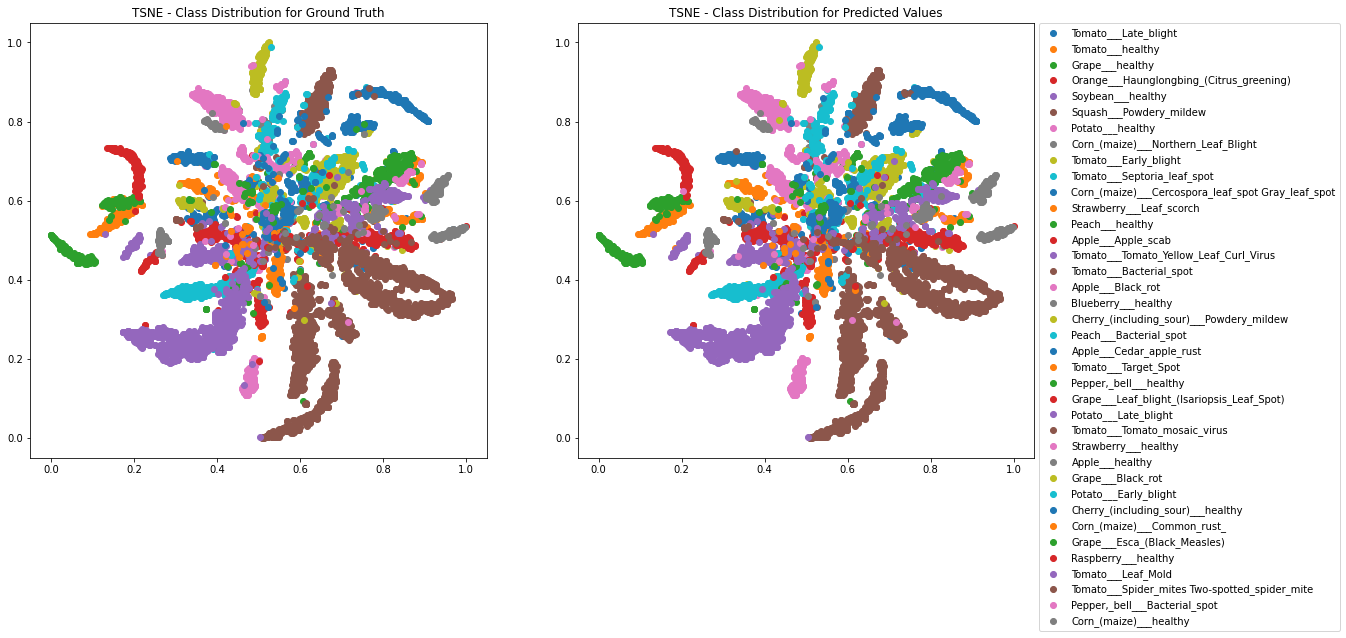

In [42]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_gt = tsne[:, 0]
ty_gt = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_gt = scale_to_01_range(tx_gt)
ty_gt = scale_to_01_range(ty_gt)


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_pred = tsne[:, 0]
ty_pred = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_pred = scale_to_01_range(tx_pred)
ty_pred = scale_to_01_range(ty_pred)


# visualize the plot
visualize_both_tsne_points(diseases, tx_gt, ty_gt, y_true, tx_pred, ty_pred, y_pred, 'TSNE - Class Distribution for Ground Truth', 'TSNE - Class Distribution for Predicted Values')